In [13]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# Hands-on Activity 14.3: Bayesian linear regression

## Objectives

+ To demonstrate how epistemic uncertainty can be quantitied.


## Example (Linear)
Let's start with a simple example where we just have to find a linear fit.
Here are some synthetic data:

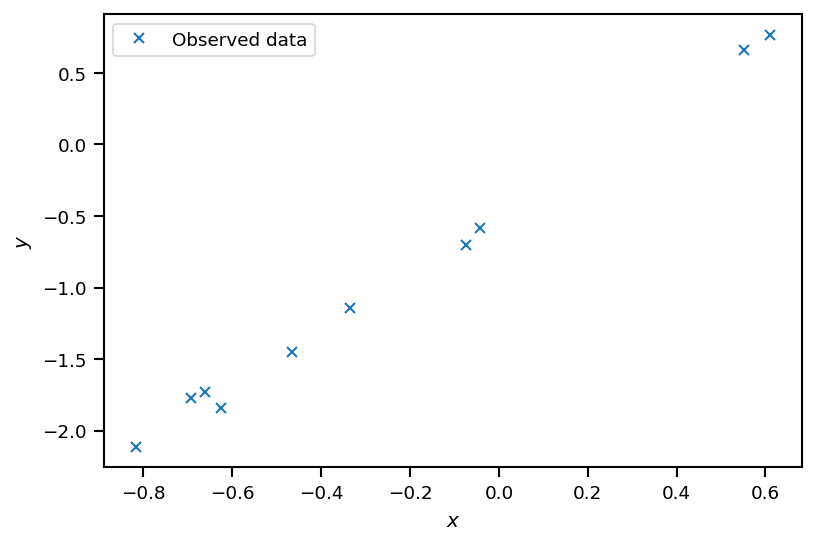

In [14]:
# How many observations we have
num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
sigma_true = 0.1
y = w0_true + w1_true * x + sigma_true * np.random.randn(num_obs)
# Let's plot the data
fig, ax = plt.subplots(dpi=150)
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

Let's also copy-paste the code for creating design matrices for the three generalized linear models we have considered so far:

In [15]:
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """
    Fourier expansion with ``num_terms`` cosines and sines.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(1, int(num_terms / 2)):
        cols.append(np.cos(2 * i * np.pi / L * x))
        cols.append(np.sin(2 * i * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

We saw that for Gaussian likelihood and weightp prior, the posterior of the weights is Gaussian:
$$
p(\mathbf{w}|\mathbf{x}_{1:n},\mathbf{y}_{1:n}, \sigma, \alpha) = \mathcal{N}\left(\mathbf{w}|\mathbf{m}, \mathbf{S}\right),
$$
where
$$
\mathbf{S} = \left(\sigma^{-2}\mathbf{\Phi}^T\mathbf{\Phi}+\alpha\mathbf{I}\right)^{-1},
$$
and
$$
\mathbf{m} = \sigma^{-2}\mathbf{S}\Phi^T\mathbf{y}_{1:n}.
$$
Let's write some code that finds the posterior weight mean vector $\mathbf{m}$ and the posterior weight covariance matrix $\mathbf{S}$:

In [16]:
# I need this to take the Cholesky decomposition
import scipy

def find_m_and_S(Phi, y, sigma2, alpha):
    """
    Return the posterior mean and covariance of the weights of a Bayesian linear regression problem with
    design matrix ``Phi`` observed targets ``y``, noise variance ``sigma2``
    and priors for the weights ``alpha``.
    """
    A = np.dot(Phi.T, Phi) / sigma2 + alpha * np.eye(Phi.shape[1])
    L = scipy.linalg.cho_factor(A)
    m = scipy.linalg.cho_solve(L, np.dot(Phi.T, y / sigma2))
    S = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1]))
    return m, S

Let's apply this to the synthetic dataset.

In [17]:
import scipy.stats as st

# Select polynomial degree and get design matrix
degree = 1
# The design matrix
Phi = get_polynomial_design_matrix(x[:, None], degree)

# We need to pick variance by hand for now (here I am using the true one)
sigma2 = 0.5 ** 2
# We also need to pick the regularization parameter by hand:
alpha = 5.0
# Here is the prior for the weights as a distribution:
w_prior = st.multivariate_normal(mean=np.zeros(degree+1), cov=alpha * np.eye(degree+1))
# Get the posterior mean and covariance for the weights:
m, S = find_m_and_S(Phi, y, sigma2, alpha)
# The posterior of the weights as a distribution:
w_post = st.multivariate_normal(mean=m, cov=S)

Now let's plot contours of the prior and the posterior.

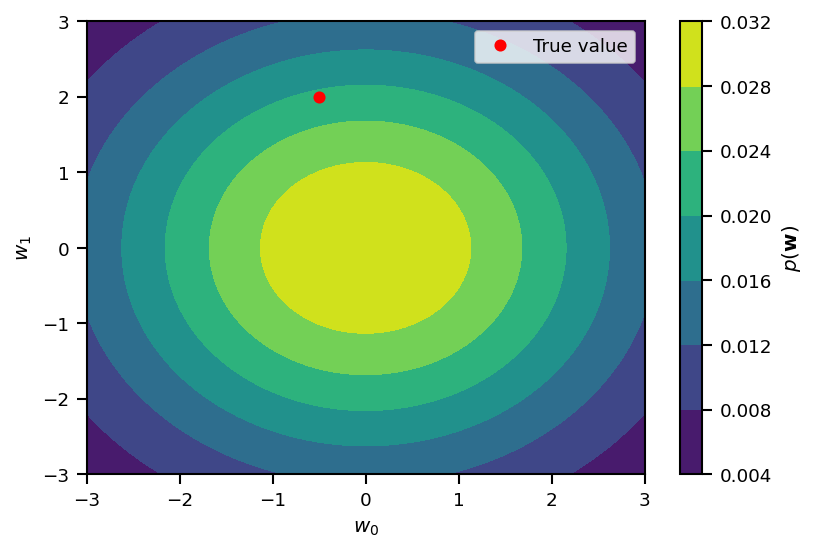

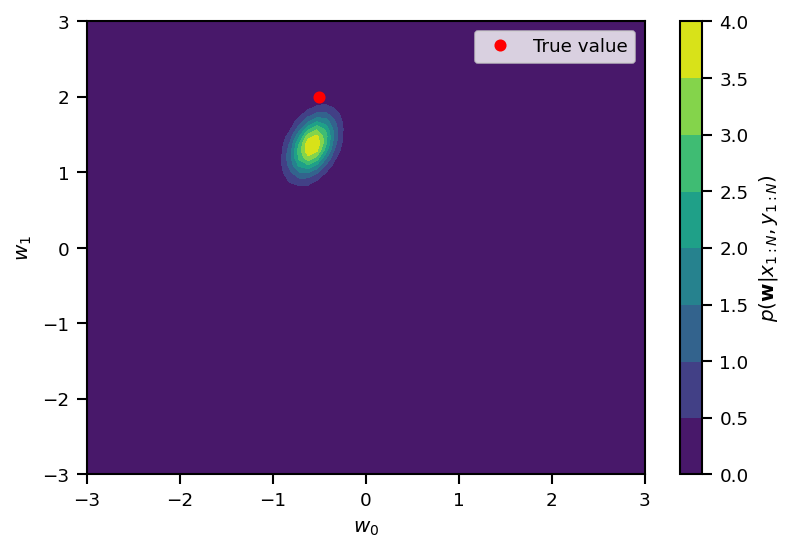

In [18]:
# Plot the contours of the prior and the posterior
fig, ax = plt.subplots(dpi=150)
ws = np.linspace(-3.0, 3.0, 64)
W1, W2 = np.meshgrid(ws, ws)
w_all = np.hstack([W1.flatten()[:, None], W2.flatten()[:, None]])
W_prior_pdf = w_prior.pdf(w_all).reshape(W1.shape)
c = ax.contourf(W1, W2, W_prior_pdf)
ax.plot(w0_true, w1_true, 'ro', label='True value');
plt.legend(loc='best')
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')
plt.colorbar(c, label='$p(\mathbf{w})$');

# Plot the posterior
fig, ax = plt.subplots(dpi=150)
W_post_pdf = w_post.pdf(w_all).reshape(W1.shape)
c = ax.contourf(W1, W2, W_post_pdf)
ax.plot(w0_true, w1_true, 'ro', label='True value');
plt.legend(loc='best')
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')
plt.colorbar(c, label='$p(\mathbf{w}|x_{1:N}, y_{1:N})$');

Let's visualize some prior samples of the weights.
What we do below is just sampling from the prior of the weights and drawing the line that corresponds to each sample. Notice that the lines are all over the place. Some have positive slope. Some are negative slope. Some cut the x-axis and some don't. That's fine. We have so much uncertainty because we haven't seen the data yet.

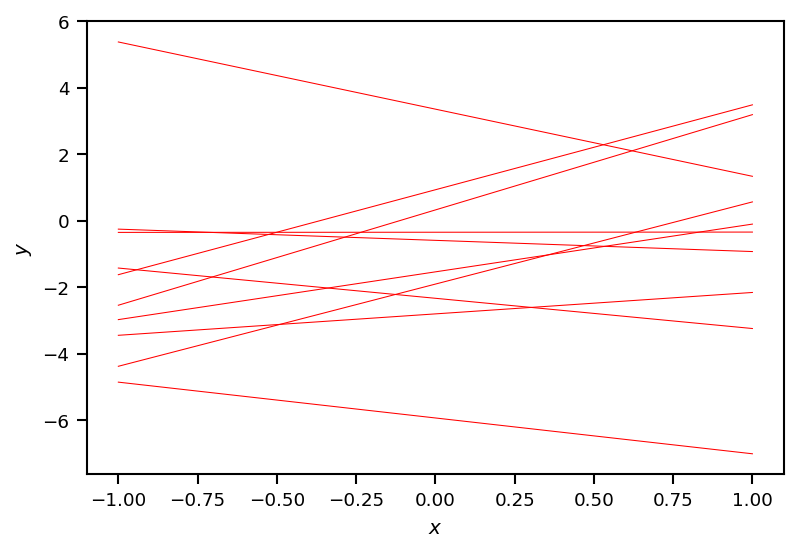

In [19]:
# Prior samples
# Plot the results
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
for _ in range(10):
    w_sample = w_prior.rvs()
    yy_sample = np.dot(Phi_xx, w_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Now let's do the same thing, but instead of sampling the weights from the prior, let's sample them from the posterior.
Notice that we there is much less (epistemic) uncertainty now that we are taking the data into account.

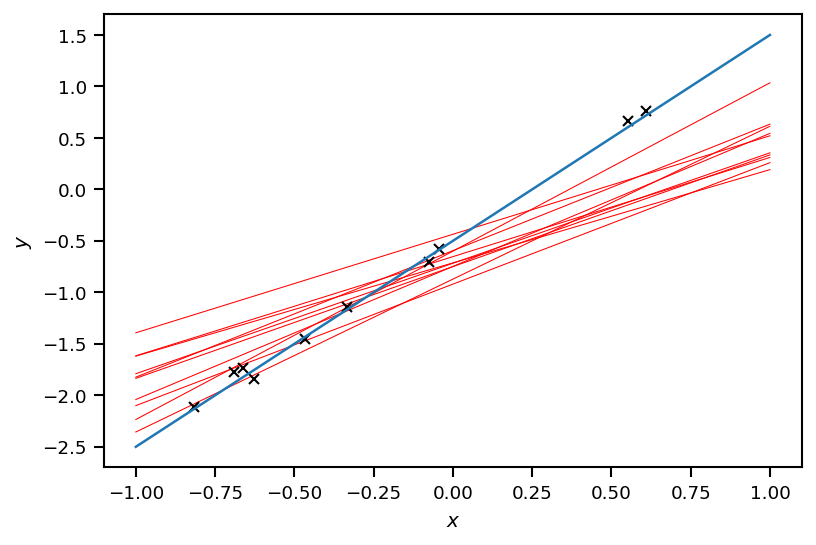

In [20]:
# Posterior samples
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
for _ in range(10):
    w_sample = w_post.rvs()
    yy_sample = np.dot(Phi_xx, w_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

### Questions

+ Rerun the code cells above with a very small $\alpha$. What happens?
+ Rerun he code cells above with a very big $\alpha$. What happens?
+ Fix $\alpha$ to $5$ and rerun the code cells above with a very small and the very big value for $\sigma$. What happens in each case?

## Example (Quadratic)

Let's repeat what we did above with a quadratic example.
Here are some synthetic data:

In [ ]:
# How many observations we have
num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = w0_true + w1_true * x + w2_true * x ** 2 + sigma_true * np.random.randn(num_obs)
# Let's plot the data
fig, ax = plt.subplots(dpi=150)
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

Here is how we fit a $7$ degree polynomial:

In [ ]:
# Select polynomial degree and get design matrix
degree = 7
Phi = get_polynomial_design_matrix(x[:, None], degree)# Pick variance (here I am using the true one)
sigma2 = 0.01 ** 2
# Pick the regularization parameter:
alpha = 5.0
# The prior for the weights
w_prior = st.multivariate_normal(mean=np.zeros(degree+1), cov=alpha * np.eye(degree+1))
# Solve for the MAP of the weights:
m, S = find_m_and_S(Phi, y, sigma2, alpha)
# The posterior of the weights
w_post = st.multivariate_normal(mean=m, cov=S)

Let's visualize some samples from the prior:

In [ ]:
# Prior samples
# Plot the results
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
for _ in range(10):
    w_sample = w_prior.rvs()
    yy_sample = np.dot(Phi_xx, w_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Let's visualize some samples from the posterior:

In [ ]:
# Posterior samples
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
for _ in range(10):
    w_sample = w_post.rvs()
    yy_sample = np.dot(Phi_xx, w_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

### Questions

+ Rerun the code cells above with a very small $\alpha$. What happens?
+ Rerun he code cells above with a very big $\alpha$. What happens?
+ Fix $\alpha$ to $5$ and rerun the code cells above with a very small and the very big value for $\sigma$. What happens in each case?